In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_hub as hub

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
print(tf.__version__)

1.15.0


In [3]:
import numpy as np
import pandas as pd
import os
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%matplotlib inline
import cv2
from collections import defaultdict
from IPython.display import SVG
from tqdm.notebook import tqdm
from PIL import Image

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8247341103183105520
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4773123164518852408
physical_device_desc: "device: XLA_CPU device"
]


2023-05-29 12:36:46.408108: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-05-29 12:36:46.416092: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300010000 Hz
2023-05-29 12:36:46.417719: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56fdcb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-05-29 12:36:46.417746: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-05-29 12:36:46.419176: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/env/env37/lib/python3.7/site-packages/cv2/../../lib64:
2023-05-29 12:36:46.419202: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed

In [5]:
#!git clone https://www.github.com/matterport/Mask_RCNN.git
#os.chdir('Mask_RCNN')

In [6]:
#!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
#!ls -lh mask_rcnn_coco.h5

In [7]:
import sys
# Root directory of the project
#ROOT_DIR = os.path.abspath("../../")
ROOT_DIR = ('./Mask_RCNN/')
# Import Mask RCNN
sys.path.append(ROOT_DIR)  
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log


# Directory to save logs and trained model
#MODEL_DIR = os.path.join(ROOT_DIR, "../output/kaggle/working/logs")
MODEL_DIR = ('./Mask_RCNN')

Using TensorFlow backend.


In [8]:
class DetectorConfig(Config):
   
    # Configuration name  
    NAME = 'instances'
    
    # We have one GPU available, but can put multiple images on it
    # Batch size is 8 (GPUs * images/GPU)
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet101' #'resnet101' would be another option
    
    NUM_CLASSES = 2  # background + pneumonia classes -->semantic segmentation
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    TRAIN_ROIS_PER_IMAGE = 32 #or 16
    MAX_GT_INSTANCES = 4 #or 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  #or 0.7
    DETECTION_NMS_THRESHOLD = 0.01 #or 0.3
    STEPS_PER_EPOCH = 200 #or 500
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [9]:
sys.path.append(os.path.join('Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
 
#!cd coco_weight && wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
#!ls -lh mask_rcnn_coco.h5
COCO_WEIGHTS_PATH = "./Mask_RCNN/mask_rcnn_coco.h5"

In [10]:
MODEL_DIR
COCO_WEIGHTS_PATH

'./Mask_RCNN/mask_rcnn_coco.h5'

In [11]:
# Create model in training mode
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [12]:
image_path = './work/test'
file_list = os.listdir(image_path)
type(file_list)
test_df = pd.DataFrame(file_list)
test_df.rename(columns = {0:'image_ids'}, inplace = True)

In [13]:
test_df.head()

image_ids
0  630bfd0977553ecb.jpg
1  e944d6d8bdadf55f.jpg
2  fbd4cf58bd6d3671.jpg
3  e718f153a98fd9c1.jpg
4  17d04e21329d79fb.jpg

(768, 977, 3)


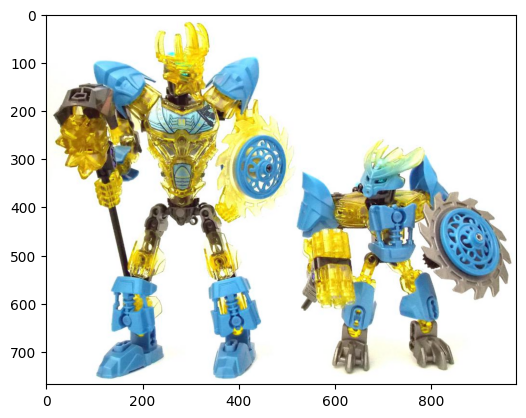

In [14]:
img = cv2.imread(os.path.join(image_path, "630bfd0977553ecb.jpg"))
plt.imshow(img)
IMG_SHAPE = img.shape
print (IMG_SHAPE)

In [15]:
def display_images(flnames):
    f, ax = plt.subplots(3,4, figsize=(20,40))
    image_path = './work/test/'
    #for img in path.iterdir():

    for i, fl in enumerate(flnames):
        ax[i//4,i%4].set_axis_off()
        img = cv2.imread( image_path+fl)
        ax[i//4,i%4].imshow(img)
        ax[i//4,i%4].set_title(f'{fl}')
        f.tight_layout()

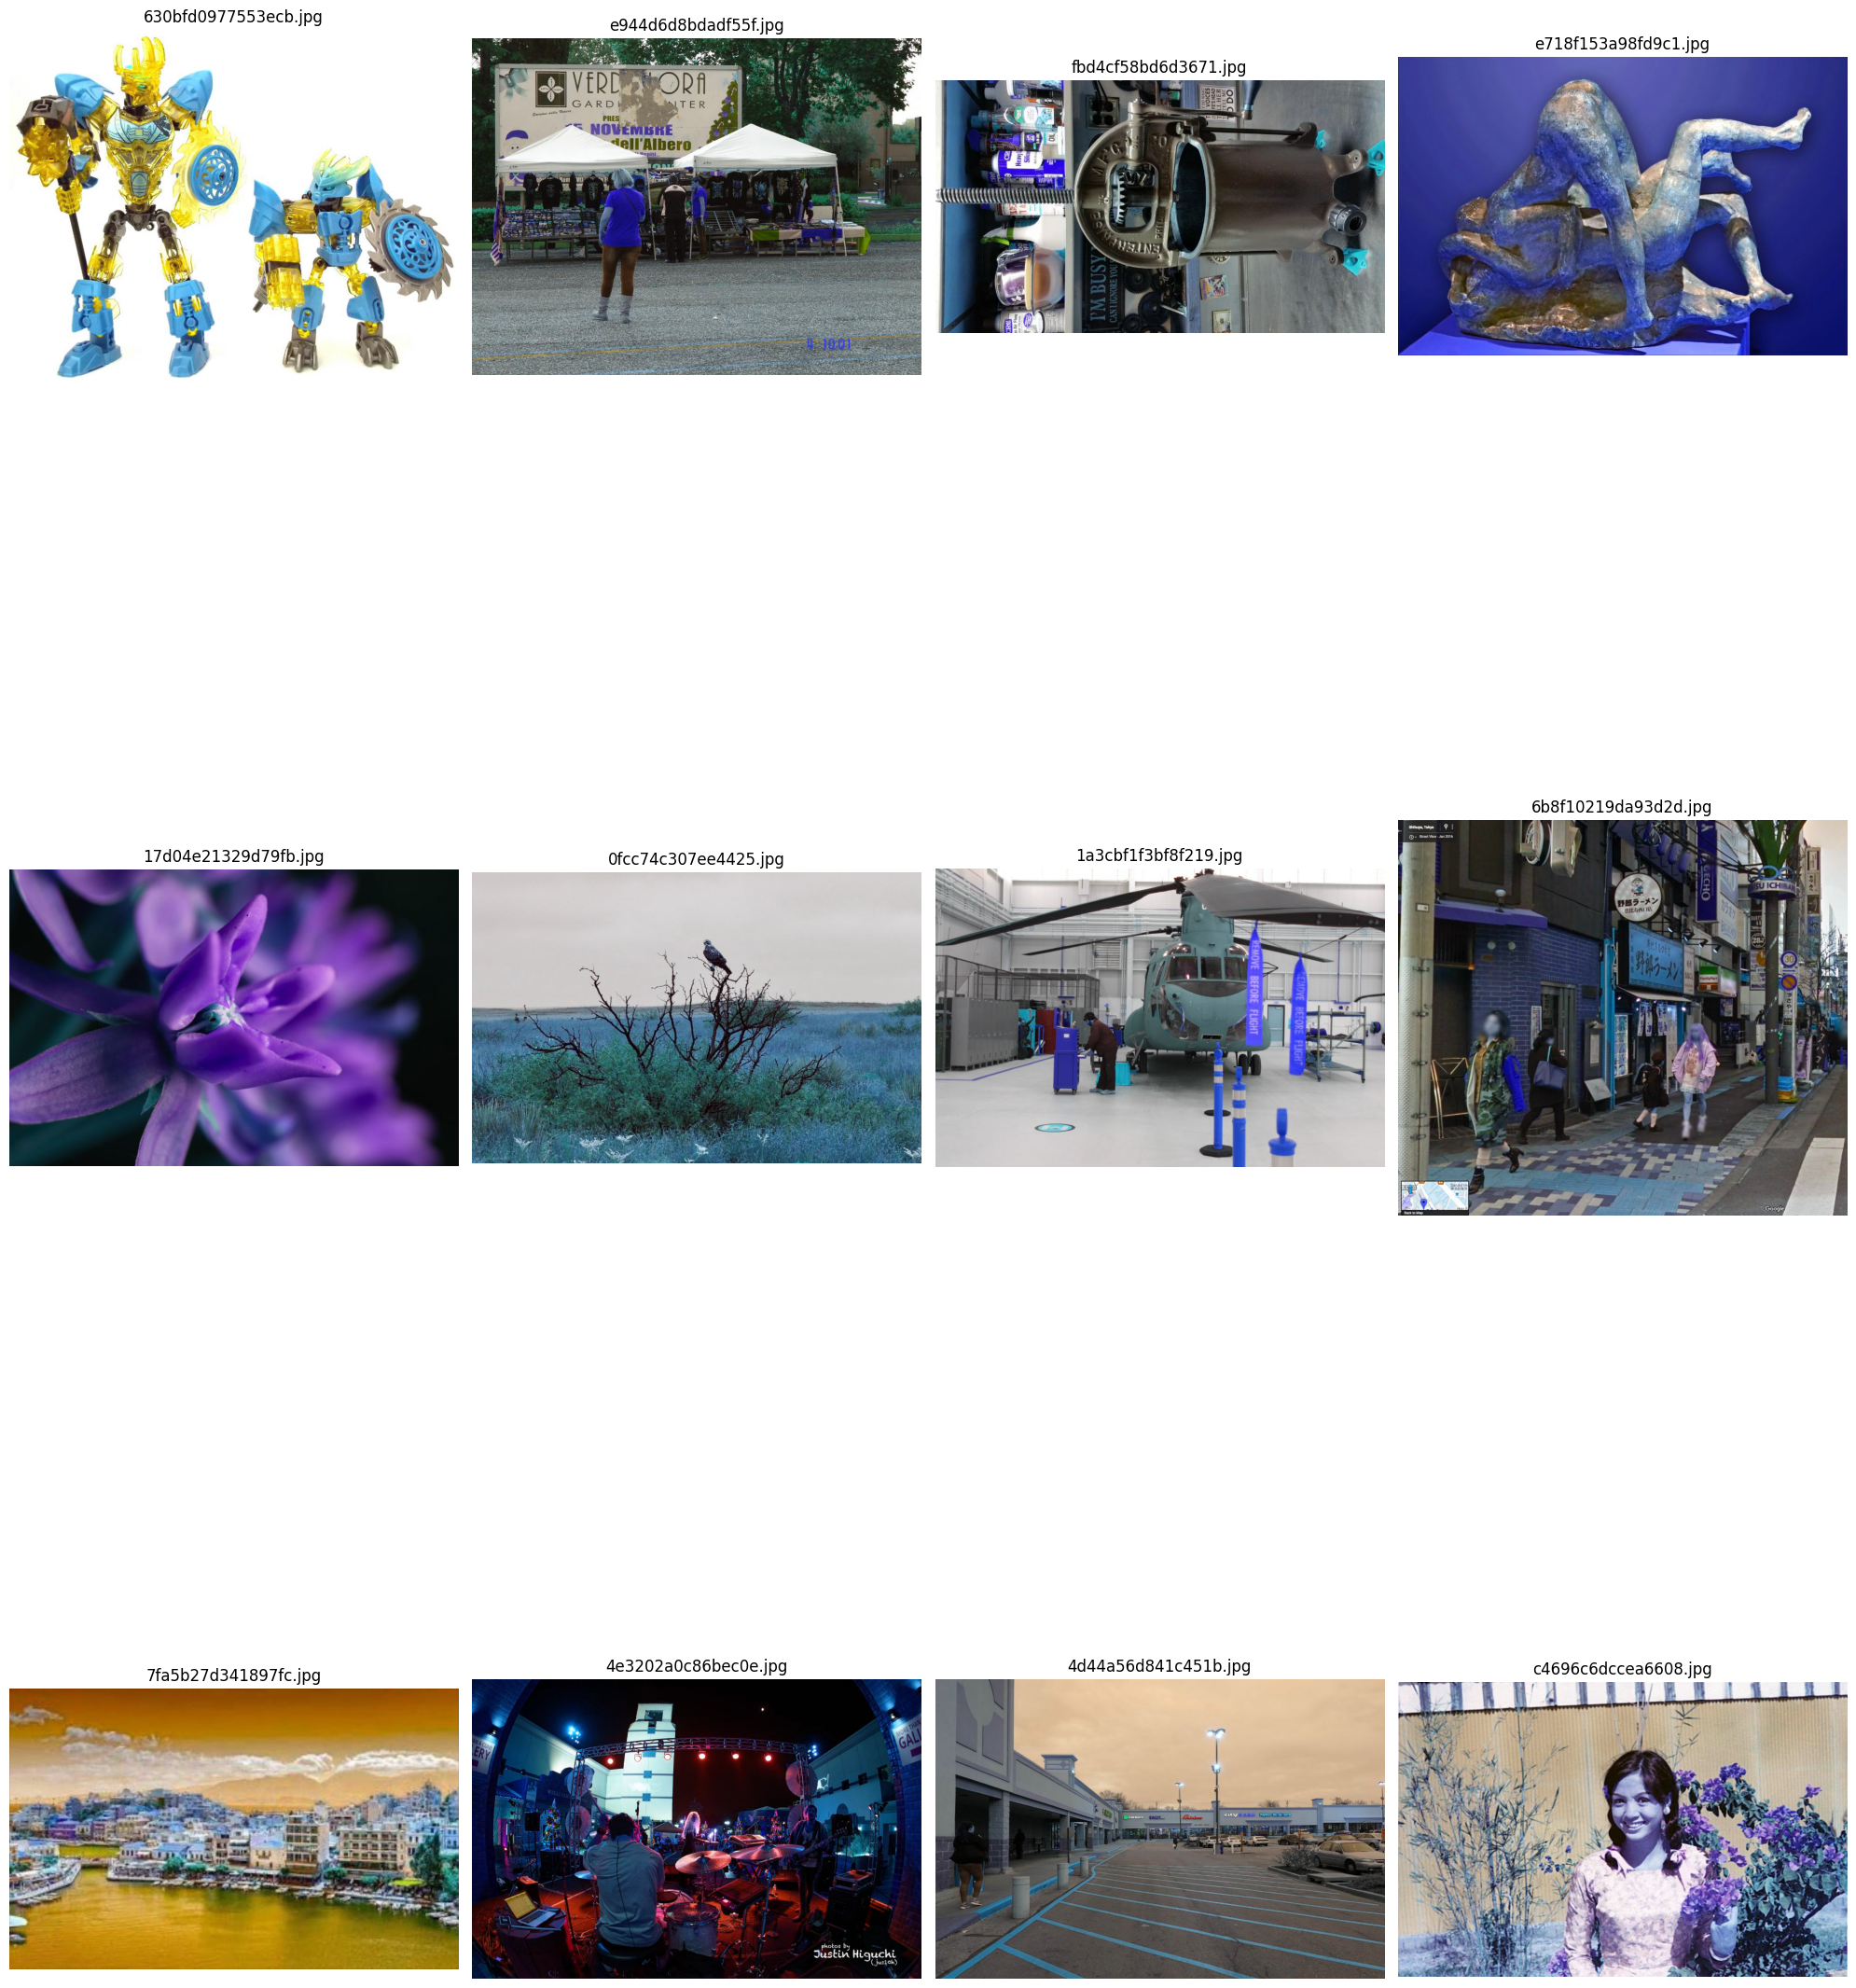

In [16]:
display_images(list(test_df['image_ids'][:12]))

In [17]:
def resize_image(image):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [18]:
#hs, ws = [], []
test_df['height'] = ""
test_df['weight'] = ""
#test_df = pd.DataFrame(file_list)
for i, row in tqdm(test_df.iterrows(), total = len(test_df)): #total = len(test_df)):
    img = Image.open(Path(image_path)/(test_df['image_ids'][i]))
    h, w = img.size
    test_df['height'][i] = h
    test_df['weight'][i] = w
    #hs.append(h)
    #ws.append(w)


  0%|          | 0/99999 [00:00<?, ?it/s]

In [19]:
test_df.head(5)

image_ids height weight
0  630bfd0977553ecb.jpg    977    768
1  e944d6d8bdadf55f.jpg   1024    768
2  fbd4cf58bd6d3671.jpg   1024    576
3  e718f153a98fd9c1.jpg   1024    682
4  17d04e21329d79fb.jpg   1024    678

In [20]:
test_df.to_csv('./work/test_df.csv')



Instructions for updating:
Use `tf.cast` instead.


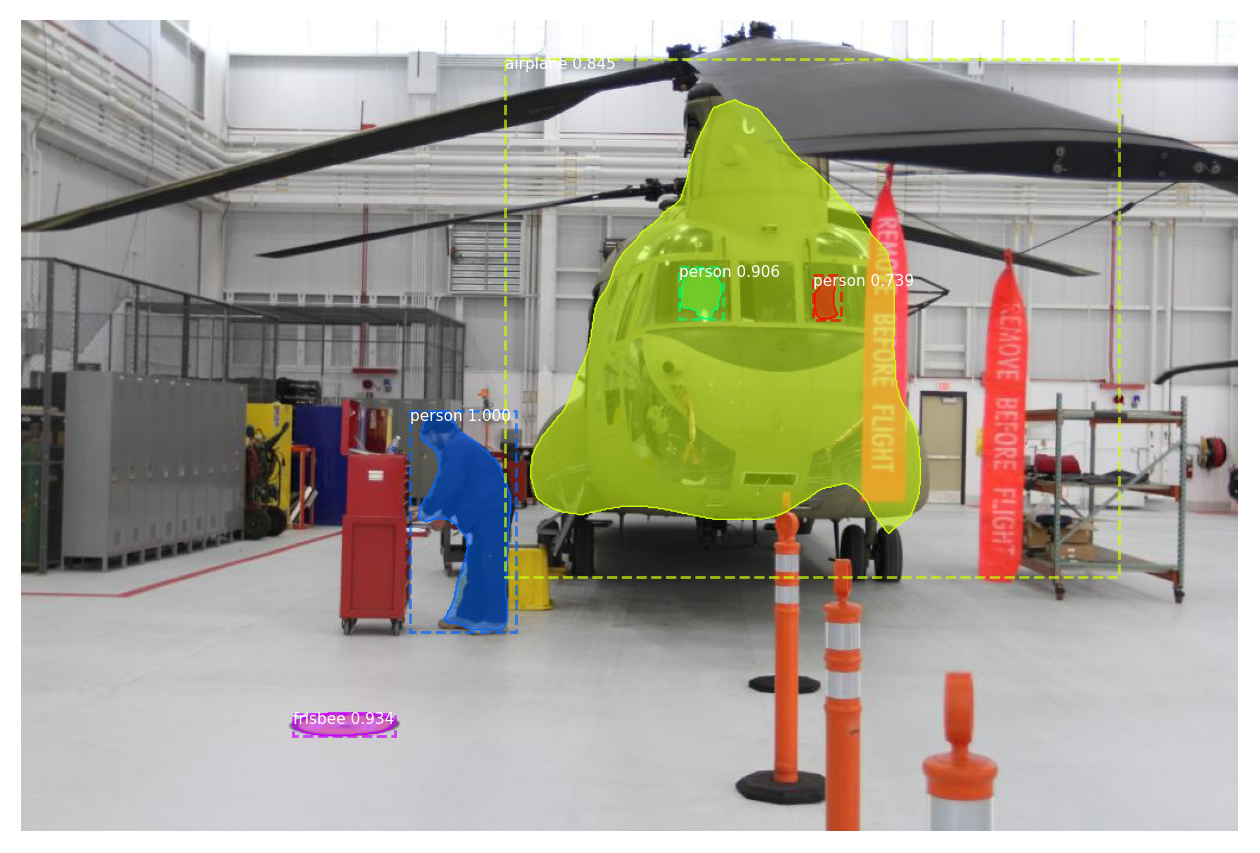

In [21]:
# example of inference with a pre-trained coco model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
 
# define 81 classes that the coco model knows about

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

#class_names = ['car','Car'] 
# define the test configuration
class ImgConfig(Config):
     NAME = "images"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 80

# define the model
rcnn = MaskRCNN(mode='inference', model_dir=MODEL_DIR, config=ImgConfig())
# load coco model weights
rcnn.load_weights(COCO_WEIGHTS_PATH, by_name=True)
# load image
img = load_img(os.path.join(image_path, test_df['image_ids'][6]))
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# get dictionary for first prediction
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
#if (class_names == 'car'):
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

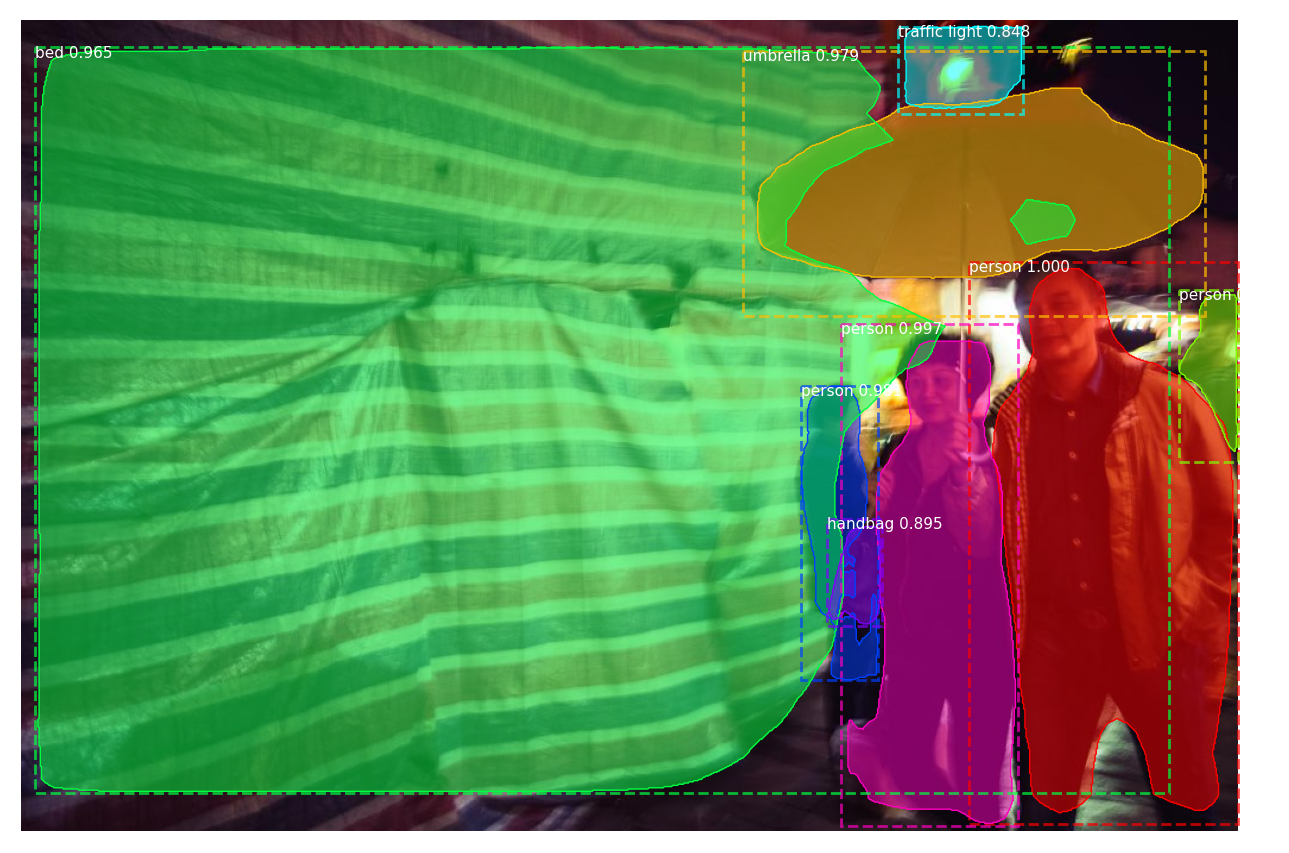

In [22]:
# load image
img = load_img(os.path.join(image_path, test_df['image_ids'][100]))
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# get dictionary for first prediction
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
#if (class_names == 'car'):
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

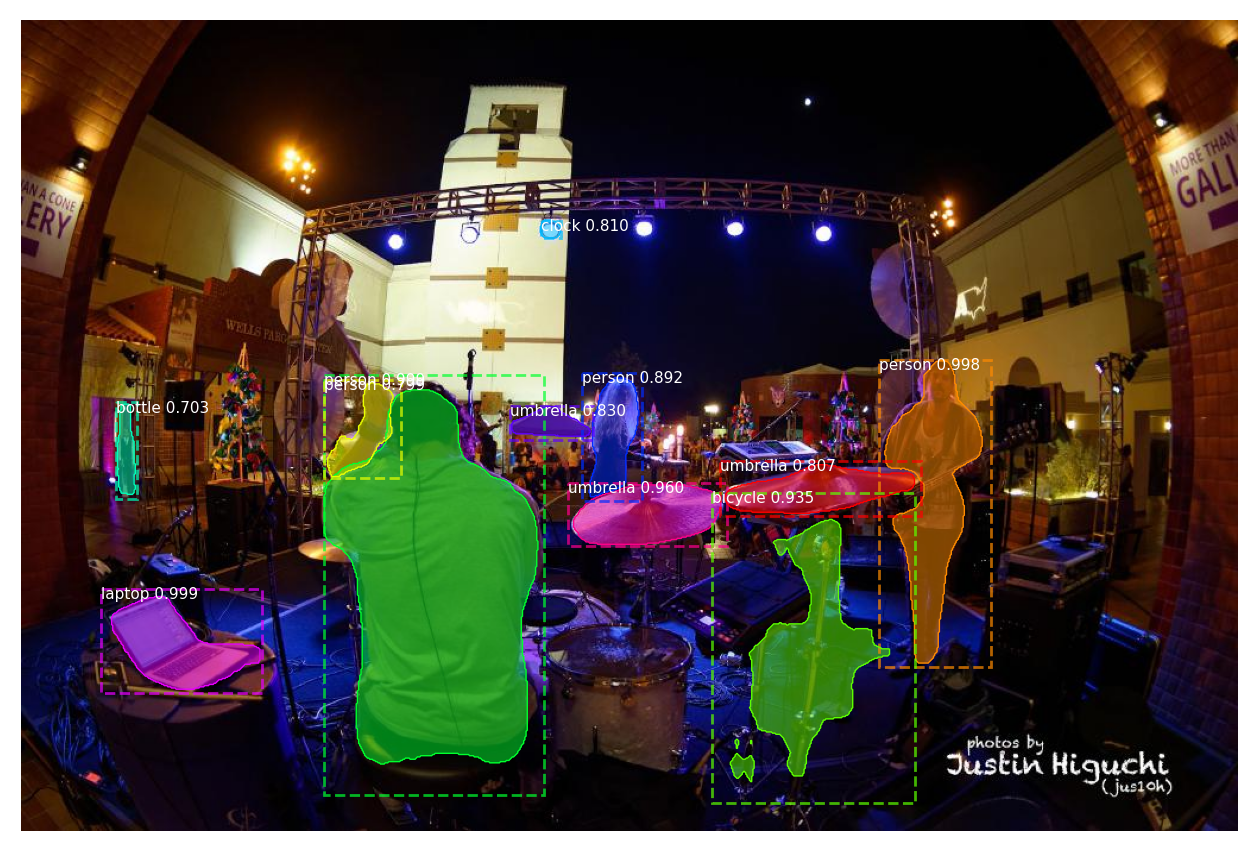

In [23]:
# load image
img = load_img(os.path.join(image_path, test_df['image_ids'][9]))
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# get dictionary for first prediction
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
#if (class_names == 'car'):
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
